In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('font', family='Malgun Gothic',size=8, weight = 'bold')

In [2]:
#1. 데이터 가져오기
파일 = pd.ExcelFile('C:\ETF\portfolio_monthly_data.xlsx')
자산군 = 파일.sheet_names
print (자산군)

['국가', '채권', '현금', '섹터', '팩터']


In [3]:
#2. 자산군별 데이터 프레임 설정

자료 = {}
for i in 자산군:
    자료[i] = 파일.parse(i)
    자료[i].index = 자료[i].Date
    #날짜 있는 컬럼을 삭제함.
    자료[i].drop('Date', axis = 1, inplace=True)
    #날짜 컬럼을 제외한 컬럼의 갯수
    print(i+'개수',len(자료[i].columns))

국가개수 7
채권개수 5
현금개수 1
섹터개수 15
팩터개수 8


In [4]:
자료['현금'].columns

Index(['KODEX단기채권'], dtype='object')

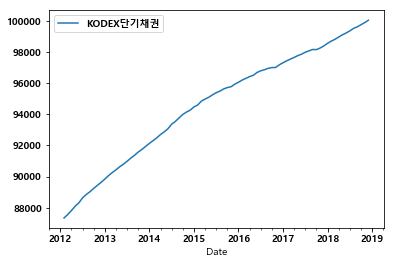

In [5]:
자료["현금"].plot()

In [6]:
자료['현금'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 1 columns):
KODEX단기채권    83 non-null int64
dtypes: int64(1)
memory usage: 1.3 KB


In [7]:
자료["국가"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 7 columns):
KODEX200              83 non-null int64
KODEX코스닥150           83 non-null int64
KODEX미국S&P500선물(H)    83 non-null int64
KODEX일본TOPIX100       83 non-null int64
TIGER유로스탁스50(합성 H)    83 non-null int64
KODEX중국본토 A50         83 non-null int64
KINDEX베트남VN30(합성)     83 non-null int64
dtypes: int64(7)
memory usage: 5.2 KB


In [8]:
자료["채권"].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2012-02-29 to 2018-12-31
Data columns (total 5 columns):
KOSEF국고채10년    83 non-null int64
KODEX국고채3년     83 non-null int64
KOSEF미국달러선물    83 non-null int64
TIGER일본엔선물     83 non-null int64
KODEX단기채권      83 non-null int64
dtypes: int64(5)
memory usage: 3.9 KB


In [9]:
#3. 함수 설정

def 월간수익률(데이터):
    #월별 수익률 = 금월 데이터/전월 데이터
    return 데이터 / 데이터.shift(1)

def 변동성대비모멘텀(데이터):
    a = 데이터/데이터.shift(12)
    b = 월간수익률(데이터).rolling(12).std()
    return a/b

def 연평균수익률(데이터):
    return 데이터/데이터.shift(12)

def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

In [10]:
def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

In [11]:
def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

In [12]:
def 평균모멘텀스코어6(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 7):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/6
    return a

In [13]:
x = 월간수익률(자료['현금'])*0.25
y = 월간수익률(자료["국가"])*평균모멘텀스코어(자료["국가"]).shift(1)
c = x.values + y.values

In [14]:
# 현금 비중 지정, 보수적(1), 보통(0.5), 공격적(0.25)
def 현금혼합모멘텀수익곡선(데이터, 현금비율=0.25):
    x = 월간수익률(자료['현금'])*현금비율
    y = 월간수익률(데이터)*평균모멘텀스코어(데이터).shift(1)
    a = pd.DataFrame((y.values+x.values)/(현금비율+평균모멘텀스코어(데이터).shift(1).values)).cumprod() 
    a.index = 데이터.index
    a.columns = 데이터.columns
    return a

def 자산군통합포트(데이터, 순위, 자산군비중):
    x = 월간수익률(현금혼합모멘텀수익곡선(데이터))
    y = np.where(모멘텀순위(데이터, 순위).shift(1)==0,np.nan,자산군비중/순위)
    z = ((x*y).sum(1)).dropna()
    z = z.replace(0, np.nan)
    return z

#자산군별 모멘텀 랭킹 상위 종목 개수 선정
def 통합모멘텀(국가비중,섹터비중,팩터비중,채권비중):
    a = 자산군통합포트(자료['국가'],4,국가비중)  #자산군통합포트(자료,상위종목수,비중)
    b = 자산군통합포트(자료['섹터'],8,섹터비중)
    c = 자산군통합포트(자료['팩터'],10,팩터비중)
    d = 자산군통합포트(자료['채권'],1,채권비중)
    e = (pd.concat([a, b, c, d], axis=1).sum(1)/(국가비중+섹터비중+팩터비중+채권비중))
    e = e.replace(0,np.nan).cumprod()
    e.columns = ['통합수익']
    return e

In [28]:
#4. 결과 plot

# 현금의 월간 수익률 구하기
x = 월간수익률(자료['현금'])
국가비중 = 1 ; 섹터비중 = 1 ; 팩터비중 = 1 ; 채권비중 = 1
# 전략의 통합모멘텀 구하기
# 인덱스는 현금의 인덱스로 업데이트한다. 이것은 raw데이타의 인덱스 일치해야 함을 뜻한다
y = pd.DataFrame(통합모멘텀(국가비중,섹터비중,팩터비중,채권비중), index = x.index)

In [29]:
# 전략의 6개월 모멘텀, 월간수익률구하기
a = pd.DataFrame((월간수익률(y).values*평균모멘텀스코어6(y).shift(1).values+(1-평균모멘텀스코어6(y).shift(1).values)*x.values), index = x.index).cumprod().dropna()

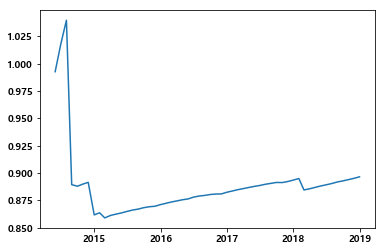

In [30]:
plt.plot(a)
plt.show()

In [31]:
b = 자료['국가'].KODEX200/자료['국가'].KODEX200.iloc[0]

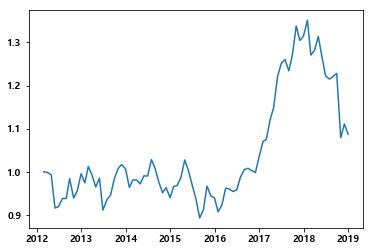

In [32]:
plt.plot(b)

In [33]:
c = pd.concat([a, b], axis=1).dropna()

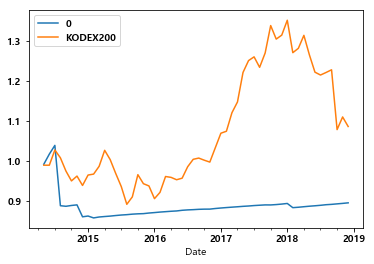

In [34]:
c.plot()

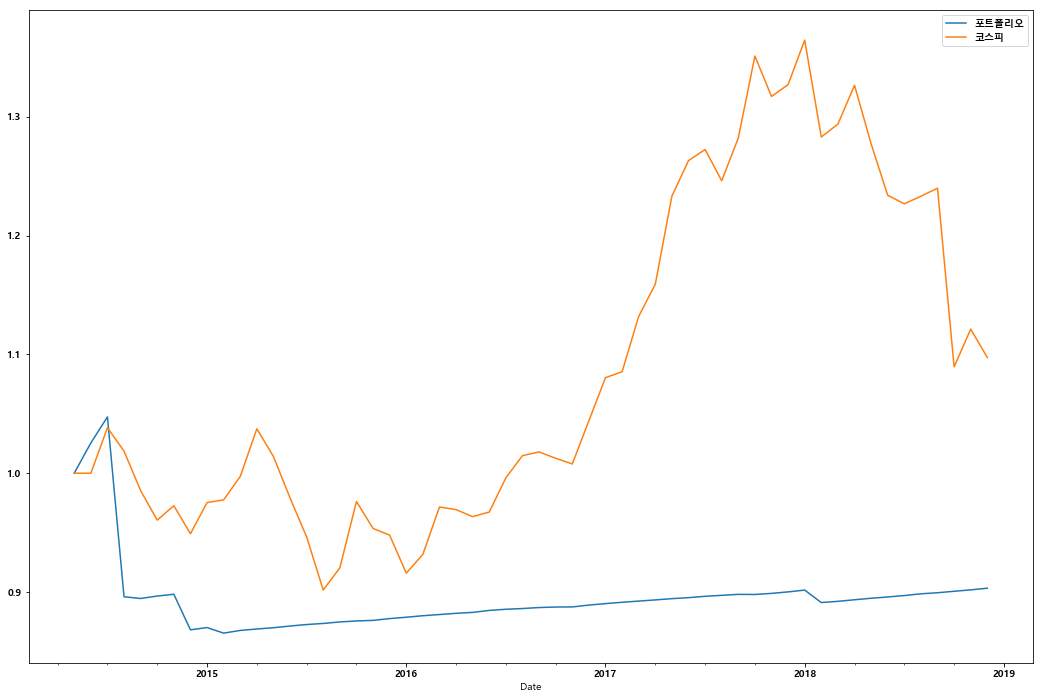

In [35]:
c.columns = ['포트폴리오', '코스피']
c.divide(c.iloc[0]).plot(figsize = (18,12))
plt.show()

In [23]:
c.tail()

,포트폴리오,코스피
Date,,
2018-08-31,0.945169,1.221196
2018-09-28,0.946109,1.227942
2018-10-31,0.947410,1.078993
2018-11-30,0.948673,1.110475
2018-12-31,0.950127,1.086761


In [24]:
최대하락 = c.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락 = c.포트폴리오/최대하락 - 1.0
최대하락.tail()

Date
2018-08-31    1.033033
2018-09-28    1.033033
2018-10-31    1.033033
2018-11-30    1.033033
2018-12-31    1.033033
Freq: BM, Name: 포트폴리오, dtype: float64

In [25]:
당월하락.tail()

Date
2018-08-31   -0.085055
2018-09-28   -0.084145
2018-10-31   -0.082885
2018-11-30   -0.081662
2018-12-31   -0.080256
Freq: BM, Name: 포트폴리오, dtype: float64

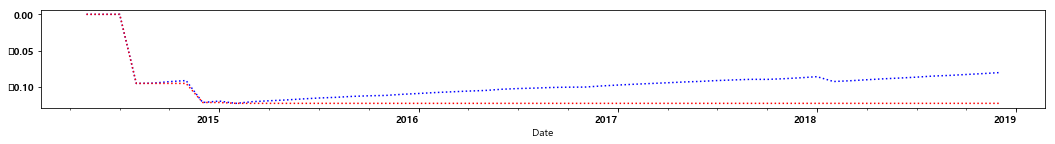

In [26]:
#5. MDD
최대하락 = c.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락 = c.포트폴리오/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), color = 'blue', linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

In [27]:
#6. MDD / CAGR
투자기간 = len(c.index)/12
print("MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("CAGR : "+str(c.포트폴리오[-1]**(1/투자기간)*100-100)[0:4]+"%")

MDD : -12.2%
CAGR : -1.0%
